starting...
x_train shape =  (700165, 77)
y_train shape = (700165,)
Some useful info to get an insight on dataset's shape and normalisation:
features shape, labels shape, each features mean, each features standard deviation
(120516, 77) (120516,) -0.025180602413949066 0.6998221188698709
x_test shape = (120516, 77)
y_test shape = (120516,)
the dataset is therefore properly normalised, as expected.
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
segmenting signal...
signal segmented.
train_x shape = (63650, 23, 77)
train_y shape = (63650,)
test_x shape = (10955, 23, 77)
test_y shape = (10955,)
unique test_y [0 1]
unique train_y [0 1]
test_y[1]= [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
train_y shape(1-hot) = (63650, 18)
test_y shape(1-hot) = (10955, 18)
opportunity dataset
train_x_reshaped =  (63650, 1, 23, 77)
test_x_reshaped =  (10955, 1, 23, 77)
train_x shape = (63650, 1, 23, 77)
train_y shape = (63650, 18)
test_x shape = (10

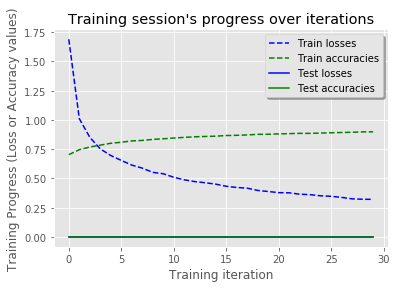

TypeError: must be str, not int

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import tensorflow as tf
import time
from sklearn import metrics
import h5py
import os
import sys
import matplotlib.pyplot as plt
#%matplotlib inline
plt.style.use('ggplot')

def windowz(data, size):
    start = 0
    while start < len(data):
        yield start, start + size
        start += (size / 2)
        start = int(start)

def segment_opp(x_train,y_train,window_size):
    segments = np.zeros(((len(x_train)//(window_size//2))-1,window_size,77))
    labels = np.zeros(((len(y_train)//(window_size//2))-1))
    i_segment = 0
    i_label = 0
    for (start,end) in windowz(x_train,window_size):
        if(len(x_train[start:end]) == window_size):
            m = stats.mode(y_train[start:end])
            segments[i_segment] = x_train[start:end]
            labels[i_label] = m[0]
            i_label+=1
            i_segment+=1
    return segments, labels

print("starting...")
start_time = time.time()

# DATA PREPROCESSING

# we start by reading the hdf5 files to a x_train variable, and return the segments to a train_x variable
# this applies for the test and validate sets as well.

if len(sys.argv)<2:
    print("Correct use:python script.py <valid_dataset>")
    sys.exit()


dataset = 'opp'
if dataset == "opp":
    path = os.path.join(os.path.expanduser('~'), 
                        '/Users/m193-hb/PycharmProjects/oppUCIDeepLearning/opportunityUCI-DeepLearning/phase1',
                        'opportunity.h5')
else:
    print("Dataset not supported yet")
    sys.exit()

f = h5py.File(path, 'r')


x_train = f.get('train').get('inputs')[()]
y_train = f.get('train').get('targets')[()]
x_test = f.get('test').get('inputs')[()]
y_test = f.get('test').get('targets')[()]

print("x_train shape = ", x_train.shape)
print("y_train shape =",y_train.shape)
print("Some useful info to get an insight on dataset's shape and normalisation:")
print("features shape, labels shape, each features mean, each features standard deviation")
print(x_test.shape, y_test.shape,
      np.mean(x_test), np.std(x_test))
print("x_test shape =" ,x_test.shape)
print("y_test shape =",y_test.shape)
print("the dataset is therefore properly normalised, as expected.")


print(np.unique(y_train))
print(np.unique(y_test))
unq = np.unique(y_test)

input_width = 23
if dataset == "opp":
    input_width = 23
    print("segmenting signal...")
    train_x, train_y = segment_opp(x_train,y_train,input_width)
    test_x, test_y = segment_opp(x_test,y_test,input_width)
    print("signal segmented.")
else:
    print("no correct dataset")
    exit(0)

print("train_x shape =",train_x.shape)
print("train_y shape =",train_y.shape)
print("test_x shape =",test_x.shape)
print("test_y shape =",test_y.shape)

# One-hot label conversion

train = pd.get_dummies(train_y)
test = pd.get_dummies(test_y)

train, test = train.align(test, join='inner', axis=1) # maybe 'outer' is better

train_y = np.asarray(train)
test_y = np.asarray(test)


print("unique test_y",np.unique(test_y))
print("unique train_y",np.unique(train_y))
print("test_y[1]=",test_y[1])
print("train_y shape(1-hot) =",train_y.shape)
print("test_y shape(1-hot) =",test_y.shape)


# DEFINING THE MODEL
if dataset=="opp":
    print("opportunity dataset")
    input_height = 1
    input_width = input_width #or 90 for actitracker
    num_labels = 18  #or 6 for actitracker
    num_channels = 77 #or 3 for actitracker
else:
    print("wrong dataset")
    
batch_size = 64
stride_size = 2
kernel_size_1 = 7
kernel_size_2 = 3
kernel_size_3 = 1
depth_1 = 128
depth_2 = 128
depth_3 = 128
num_hidden = 512 # neurons in the fully connected layer
dropout_1 = tf.placeholder(tf.float32) #0.1
dropout_2 = tf.placeholder(tf.float32) #0.25
dropout_3 = tf.placeholder(tf.float32) #0.5

learning_rate = 0.0005
training_epochs = 30

total_batches = train_x.shape[0] // batch_size

train_x = train_x.reshape(len(train_x),1,input_width,num_channels) # opportunity
test_x = test_x.reshape(len(test_x),1,input_width,num_channels) # opportunity
print("train_x_reshaped = " , train_x.shape)
print("test_x_reshaped = " , test_x.shape)
print("train_x shape =",train_x.shape)
print("train_y shape =",train_y.shape)
print("test_x shape =",test_x.shape)
print("test_y shape =",test_y.shape)


X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

print("X shape =",X.shape)
print("Y shape =",Y.shape)

# HIDDEN LAYERS AND FULLY CONNECTED FOR Opportunity etc
# https://www.tensorflow.org/get_started/mnist/pros

with tf.variable_scope("conv1"):
    W_conv1 = tf.get_variable("weights",[1, kernel_size_1, num_channels, depth_1],initializer=tf.random_normal_initializer())
    b_conv1 = tf.get_variable("biases", ([depth_1]),initializer=tf.random_normal_initializer())

    h_conv1 = tf.nn.relu(tf.nn.conv2d(X, W_conv1, [1,stride_size,stride_size,1], 'SAME') + b_conv1)
    # h_conv1 = tf.nn.dropout(tf.identity(h_conv1), dropout_1)
    h_conv1 = tf.nn.dropout(h_conv1, dropout_1)

    h_pool1 = tf.nn.max_pool(h_conv1,[1, kernel_size_1, kernel_size_1, 1], [1,stride_size,stride_size,1], 'SAME')

    # variable_summaries(W_conv1)
    # variable_summaries(b_conv1)
    # tf.summary.histogram('h_pool1', h_pool1)
    # tf.summary.histogram('h_pool1/sparsity', tf.nn.zero_fraction(h_pool1))

    print("hidden layer 1 shape")
    print("W_conv1 shape =",W_conv1.get_shape())
    print("b_conv1 shape =",b_conv1.get_shape())
    print("h_conv1 shape =",h_conv1.get_shape())
    print("h_pool1 shape =",h_pool1.get_shape())


# hidden layer 2
with tf.variable_scope("conv2"):
    W_conv2 = tf.get_variable("weights", [1, kernel_size_2, depth_1, depth_2])
    b_conv2 = tf.get_variable("biases", [depth_2])
    h_conv2 = tf.nn.relu(tf.nn.conv2d(h_pool1, W_conv2,[1,stride_size,stride_size,1], 'SAME') + b_conv2)
    h_conv2 = tf.nn.dropout(h_conv2, dropout_2)
    h_pool2 = tf.nn.max_pool(h_conv2,[1, kernel_size_2, kernel_size_2, 1],[1,stride_size,stride_size,1], 'SAME')

    # variable_summaries(W_conv2)
    # variable_summaries(b_conv2)
    # tf.summary.histogram('h_pool2', h_pool2)
    # tf.summary.histogram('h_pool2/sparsity', tf.nn.zero_fraction(h_pool2))


    print("hidden layer 2 shape")
    print("W_conv2 shape =",W_conv2.get_shape())
    print("b_conv2 shape =",b_conv2.get_shape())
    print("h_conv2 shape =",h_conv2.get_shape())
    print("h_pool2 shape =",h_pool2.get_shape())


# hidden layer 3
# cannot do it because the channel gets too small

# W_conv3 = weight_variable([1, kernel_size_3, depth_2, depth_3])
# b_conv3 = bias_variable([depth_3])

# h_conv3 = tf.nn.relu(depth_conv2d(h_pool2, W_conv3) + b_conv3)
# h_conv3 = tf.nn.dropout(h_conv3, dropout_3)

# h_pool3 = max_pool(h_conv3,kernel_size_3,stride_size)

# print "hidden layer 3 shape"
# print "W_conv3 shape =",W_conv3.get_shape()
# print "b_conv3 shape =",b_conv3.get_shape()
# print "h_conv3 shape =",h_conv3.get_shape()
# print "h_pool3 shape =",h_pool3.get_shape()


# fully connected layer
with tf.variable_scope("fc1"):
    #first we get the shape of the last layer and flatten it out
    shape = h_pool2.get_shape().as_list()
    print("shape's shape:", shape)

    W_fc1 = tf.get_variable("weights", [shape[1] * shape[2] * shape[3],num_hidden])
    b_fc1 = tf.get_variable("biases", [num_hidden])

    h_pool3_flat = tf.reshape(h_pool2, [-1, shape[1] * shape[2] * shape[3]])
    print("c_flat shape =",h_pool3_flat.shape)
    h_fc1 = tf.nn.relu(tf.matmul(h_pool3_flat,W_fc1) + b_fc1)
    h_fc1 = tf.nn.dropout(h_fc1, dropout_3)

    # variable_summaries(W_fc1)
    # variable_summaries(b_fc1)
    # tf.summary.histogram('h_fc1', h_fc1)
    # tf.summary.histogram('h_fc1/sparsity', tf.nn.zero_fraction(h_fc1))

with tf.variable_scope("fc2"):
    #readout layer.

    W_fc2 = tf.get_variable("weights", [num_hidden,num_labels])
    b_fc2 = tf.get_variable("biases", [num_labels])

y_conv = tf.matmul(h_fc1,W_fc2) + b_fc2

# variable_summaries(W_fc2)
# variable_summaries(b_fc2)
# tf.summary.histogram('y_conv', y_conv)
# tf.summary.histogram('y_conv/sparsity', tf.nn.zero_fraction(y_conv))


# cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=Y, logits=y_conv))
# train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)

# COST FUNCTION
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=Y, logits=y_conv))#-tf.reduce_sum(Y * tf.log(y_conv))
# optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# variable_summaries(loss,'loss')
# variable_summaries(loss)
# global_step = tf.Variable(0, dtype=tf.int32, trainable=False)

# TRAINING THE MODEL
loss_over_time_train = np.zeros(training_epochs)
accuracy_over_time_train = np.zeros(training_epochs)
loss_over_time_test = np.zeros(training_epochs)
accuracy_over_time_test = np.zeros(training_epochs)
best_accuracy = 0.0
with tf.Session() as sess:

    # merged_summary_op = tf.summary.merge_all()
    # summary_writer = tf.summary.FileWriter("./", session.graph)
    tf.initialize_all_variables().run()

    for epoch in range(training_epochs):
        cost_history_train = np.empty(shape=[0], dtype=float)
        accuracy_history_train = np.empty(shape=[0], dtype=float)
        cost_history_test = np.empty(shape=[0], dtype=float)
        accuracy_history_test = np.empty(shape=[0], dtype=float)
        for step in range(total_batches):
            offset = (step * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            # print "batch_x shape =",batch_x.shape
            # print "batch_y shape =",batch_y.shape
            # _, c, summary= session.run([optimizer, loss,merged_summary_op],feed_dict={X: batch_x, Y : batch_y, dropout_1: 1-0.1, dropout_2: 1-0.25, dropout_3: 1-0.5})
            # cost_history = np.append(cost_history,c)
            _, c, acc = sess.run([optimizer, loss, accuracy],feed_dict={X: batch_x, Y : batch_y, dropout_1: 1-0.1, dropout_2: 1-0.25, dropout_3: 1-0.5})
            cost_history_train = np.append(cost_history_train,c)
            accuracy_history_train = np.append(accuracy_history_train, acc)
            # summary_writer.add_summary(summary,global_step.eval(session=session))
        print("Epoch: ",epoch," Training Loss: ",np.mean(cost_history_train),
              " Training Accuracy: ",sess.run(accuracy, feed_dict={X: train_x, Y: train_y, dropout_1: 1-0.1, dropout_2: 1-0.25, dropout_3: 1-0.5}))
        loss_over_time_train[epoch] = np.mean(cost_history_train)
        accuracy_over_time_train[epoch] = np.mean(accuracy_history_train)
    
    print("Testing Accuracy:", sess.run(accuracy, feed_dict={X: test_x, Y: test_y, dropout_1: 1, dropout_2: 1, dropout_3: 1}))
    y_p = tf.argmax(y_conv, 1)
    val_accuracy, y_pred = sess.run([accuracy, y_p], feed_dict={X:test_x, Y:test_y, dropout_1: 1, dropout_2: 1, dropout_3: 1})
    y_true = np.argmax(test_y,1)
    # print "Precision,micro", metrics.precision_score(y_true, y_pred,average="micro")
    # print "Precision,macro", metrics.precision_score(y_true, y_pred,average="macro")
    # print "Precision,weighted", metrics.precision_score(y_true, y_pred,average="weighted")
    # #print "Precision,samples", metrics.precision_score(y_true, y_pred,average="samples")
    # print "Recall_micro", metrics.recall_score(y_true, y_pred, average="micro")
    # print "Recall_macro", metrics.recall_score(y_true, y_pred, average="macro")
    # print "Recall_weighted", metrics.recall_score(y_true, y_pred, average="weighted")
    #print "Recall_samples", metrics.recall_score(y_true, y_pred, average="samples")
    if dataset=="opp" or dataset == "pa2" :
        print("f1_score_mean", metrics.f1_score(y_true, y_pred, average="micro"))
        print("f1_score_weighted", metrics.f1_score(y_true, y_pred, average="weighted"))
        print("f1_score_macro", metrics.f1_score(y_true, y_pred, average="macro"))
        # print "f1_score_per_class", metrics.f1_score(y_true, y_pred, average=None)
    else:
        print("wrong dataset")
    # print "f1_score_micro", metrics.f1_score(y_true, y_pred, average="micro")
    # print "f1_score_macro", metrics.f1_score(y_true, y_pred, average="macro")
    # print "f1_score_weighted", metrics.f1_score(y_true, y_pred, average="weighted")
    # if dataset=="dap":
    #     print "f1_score_", metrics.f1_score(y_true, y_pred)
    #print "f1_score_samples", metrics.f1_score(y_true, y_pred, average="samples")
    print("confusion_matrix")
    print(metrics.confusion_matrix(y_true, y_pred))
    plt.figure(1)
    # indep_train_axis = np.array(range(config.batch_size, (len(loss_over_time_train)+1)*config.batch_size, config.batch_size))
    plt.plot(loss_over_time_train, "b--", label="Train losses")
    plt.plot(accuracy_over_time_train, "g--", label="Train accuracies")
    # indep_test_axis = np.array(range(config.batch_size, (len(loss_over_time_test)+1)*config.batch_size, config.batch_size))
    plt.plot(loss_over_time_test, "b-", label="Test losses")
    plt.plot(accuracy_over_time_test, "g-", label="Test accuracies")

    plt.title("Training session's progress over iterations")
    plt.legend(shadow=True)
    plt.ylabel('Training Progress (Loss or Accuracy values)')
    plt.xlabel('Training iteration')

    plt.show()
    # plt.savefig('cnn1d'+training_epochs+'.jpg')
    # fpr, tpr, tresholds = metrics.roc_curve(y_true, y_pred)
    # plt.figure(1)
    # plt.plot(loss_over_time)
    # plt.title("Loss value over epochs (CNN DG)")
    # plt.xlabel("Epoch")
    # plt.ylabel("Loss")
    # plt.show()


    #######################################################################################
    #### micro- macro- weighted explanation ###############################################
    #                                                                                     #
    # http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html      #
    #                                                                                     #
    # micro :Calculate metrics globally by counting the total true positives,             #
    # false negatives and false positives.                                                #
    #                                                                                     #
    # macro :Calculate metrics for each label, and find their unweighted mean.            #
    # This does not take label imbalance into account.                                    #
    #                                                                                     #
    # weighted :Calculate metrics for each label, and find their average, weighted        #
    # by support (the number of true instances for each label). This alters macro         #
    # to account for label imbalance; it can result in an F-score that is not between     #
    # precision and recall.                                                               #
    #                                                                                     #
    #######################################################################################

print("--- %s seconds ---" % (time.time() - start_time))
print("done.")